# Extract Köppen-Geiger Climate Composition per NUTS-2 Region

In [1]:
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# STEP 1: Load the NUTS-2 GeoJSON (High Resolution)

In [2]:
import requests
import geopandas as gpd

# ----------------------------------------------------------------------------
# Download NUTS-2 GeoJSON directly from Eurostat GISCO
# ----------------------------------------------------------------------------

# Construct the URL using the GISCO API pattern
# Pattern: https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_{SCALE}_{YEAR}_{PROJECTION}_LEVL_{LEVEL}.geojson

year = "2024"
scale = "01M"  # 1:1 Million (high resolution)
projection = "3035"  # EPSG:3035 (ETRS89-extended / LAEA Europe)
level = "2"  # NUTS level 2

url = f"https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_{scale}_{year}_{projection}_LEVL_{level}.geojson"

print(f"Downloading from:\n{url}\n")

# Download the file
response = requests.get(url)

# Check if download was successful
if response.status_code == 200:
    # Save to local file
    output_filename = f"NUTS_RG_{scale}_{year}_{projection}_LEVL_{level}.geojson"
    with open(output_filename, 'wb') as f:
        f.write(response.content)
    print(f"✓ Download successful: {output_filename}")
    print(f"  File size: {len(response.content) / (1024*1024):.2f} MB")

    # Load directly into geopandas (optional: skip saving to disk)
    nuts_2 = gpd.read_file(output_filename)
    print(f"✓ Loaded {len(nuts_2)} NUTS-2 regions into GeoDataFrame")
    print(f"  CRS: {nuts_2.crs}")

else:
    print(f"✗ Download failed with status code: {response.status_code}")
    print(f"  Error: {response.text}")

https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2024_3035_LEVL_2.geojson

✓ Download successful: NUTS_RG_01M_2024_3035_LEVL_2.geojson
  File size: 14.48 MB
✓ Loaded 299 NUTS-2 regions into GeoDataFrame
  CRS: EPSG:3035


# STEP 2: Load the Köppen-Geiger Raster and Check CRS

In [3]:
koppen_raster_path = "koppen_1991_2020.tif"  # Your file

with rasterio.open(koppen_raster_path) as src:
    print(f"Raster CRS: {src.crs}")
    print(f"Raster bounds: {src.bounds}")
    print(f"Raster shape: {src.shape}")
    raster_crs = src.crs

Raster CRS: EPSG:4326
Raster bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
Raster shape: (21600, 43200)


# STEP 3: Reproject NUTS-2 to Match Raster CRS

In [4]:
if nuts_2.crs != raster_crs:
    print(f"Reprojecting NUTS-2 from {nuts_2.crs} to {raster_crs}...")
    nuts_2 = nuts_2.to_crs(raster_crs)
    print("Reprojection complete.")

Reprojecting NUTS-2 from EPSG:3035 to EPSG:4326...
Reprojection complete.


# STEP 4: Run CATEGORICAL Zonal Statistics

In [5]:
print("Running zonal statistics (this may take 5-10 minutes for all of Europe)...")

stats = zonal_stats(
    nuts_2,
    koppen_raster_path,
    categorical=True,      # KEY: Returns counts per unique pixel value
    nodata=0,              # Treat 0 as "no data" (ocean/missing)
    all_touched=False      # Only count pixels whose CENTER is inside the polygon
)

print("Zonal statistics complete.")

Running zonal statistics (this may take 5-10 minutes for all of Europe)...
Zonal statistics complete.


# STEP 5: Convert Results to DataFrame and Normalize

In [6]:
climate_df = pd.DataFrame(stats)

# Fill NaN with 0 (if a region has no pixels of a certain climate, count = 0)
climate_df = climate_df.fillna(0)

# Calculate total pixels per region
climate_df['total_pixels'] = climate_df.sum(axis=1)

# Normalize to percentages (0.0 to 1.0)
for col in climate_df.columns:
    # Check if column is a number (climate class) and not 'total_pixels'
    if col != 'total_pixels' and isinstance(col, (int, float)):
        climate_df[f'pct_class_{col}'] = (
            climate_df[col] / climate_df['total_pixels']
        )

# Keep only the percentage columns
pct_cols = [c for c in climate_df.columns if str(c).startswith('pct_')]
climate_pct = climate_df[pct_cols].copy()

print(f"✓ Created {len(pct_cols)} climate percentage features")
print(f"\nSample columns: {pct_cols[:5]}")

✓ Created 20 climate percentage features

Sample columns: ['pct_class_14', 'pct_class_15', 'pct_class_26', 'pct_class_27', 'pct_class_29']


# STEP 6: Map Numeric Codes to Köppen Class Names

In [7]:
koppen_legend = {
    1: 'Af', 2: 'Am', 3: 'Aw', 4: 'BWh', 5: 'BWk', 6: 'BSh', 7: 'BSk',
    8: 'Csa', 9: 'Csb', 10: 'Csc', 11: 'Cwa', 12: 'Cwb', 13: 'Cwc',
    14: 'Cfa', 15: 'Cfb', 16: 'Cfc', 17: 'Dsa', 18: 'Dsb', 19: 'Dsc',
    20: 'Dsd', 21: 'Dwa', 22: 'Dwb', 23: 'Dwc', 24: 'Dwd', 25: 'Dfa',
    26: 'Dfb', 27: 'Dfc', 28: 'Dfd', 29: 'ET', 30: 'EF'
}

# Rename columns from 'pct_class_8.0' to 'pct_Csa'
renamed_cols = {}
for col in pct_cols:
    # Extract the number: 'pct_class_8.0' -> 8
    num_str = col.replace('pct_class_', '').replace('.0', '')
    if num_str.isdigit():
        climate_code = int(num_str)
        if climate_code in koppen_legend:
            renamed_cols[col] = f'pct_{koppen_legend[climate_code]}'

climate_pct.rename(columns=renamed_cols, inplace=True)

# STEP 7: Merge Back to NUTS-2 GeoDataFrame

In [8]:
final_gdf = pd.concat([
    nuts_2[['NUTS_ID', 'NUTS_NAME', 'CNTR_CODE', 'geometry']].reset_index(drop=True),
    climate_pct.reset_index(drop=True)
], axis=1)

# STEP 8: Save the Result (optional)

In [9]:
# final_gdf.drop(columns='geometry').to_csv('nuts2_koppen_climate_features.csv', index=False)

## Save as GeoPackage (with geometry, for mapping)
# final_gdf.to_file('nuts2_koppen_climate_features.gpkg', driver='GPKG')

# print("\n=== SUCCESS ===")
# print("Output files created:")
# print("  1. nuts2_koppen_climate_features.csv (for ML model)")
# print("  2. nuts2_koppen_climate_features.gpkg (for mapping)")
# print(f"\nSample of output:\n{final_gdf.head()}")

# STEP 9: Quick Validation Plot (Optional)


Validation plot saved: example_catalonia_climate.png


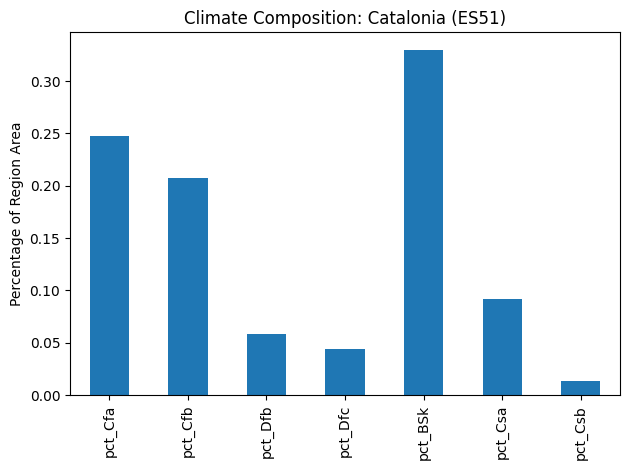

In [10]:
example_region = final_gdf[final_gdf['NUTS_ID'] == 'ES51']  # Catalonia
if not example_region.empty:
    climate_cols = [c for c in example_region.columns if c.startswith('pct_')]
    climate_dist = example_region[climate_cols].iloc[0]
    climate_dist = climate_dist[climate_dist > 0.01]  # Only show >1%

    climate_dist.plot(kind='bar', title='Climate Composition: Catalonia (ES51)')
    plt.ylabel('Percentage of Region Area')
    plt.tight_layout()

    plt.savefig('example_catalonia_climate.png', dpi=150)
    print("\nValidation plot saved: example_catalonia_climate.png")

In [11]:
display(final_gdf)

,NUTS_ID,NUTS_NAME,CNTR_CODE,geometry,pct_Cfa,pct_Cfb,pct_Dfb,pct_Dfc,pct_ET,pct_BSk,...,pct_Dsc,pct_BSh,pct_EF,pct_BWh,pct_BWk,pct_Aw,pct_Cfc,pct_Af,pct_Am,pct_Dsa
0,AT11,Burgenland,AT,"POLYGON ((17.08112 48.0877, 17.07415 48.08386,...",0.195537,0.312537,0.491926,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AT33,Tirol,AT,"MULTIPOLYGON (((12.50625 47.15306, 12.52019 47...",0.000000,0.009012,0.312289,0.394879,0.283819,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AT34,Vorarlberg,AT,"POLYGON ((9.85869 47.5344, 9.87456 47.52857, 9...",0.000000,0.176089,0.350168,0.351508,0.122235,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BE22,Prov. Limburg (BE),BE,"MULTIPOLYGON (((5.77658 50.78144, 5.78433 50.7...",0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BG34,Югоизточен,BG,"MULTIPOLYGON (((26.34894 43.03319, 26.35147 43...",0.781042,0.031202,0.126443,0.001315,0.000000,0.043965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,SE31,Norra Mellansverige,SE,"MULTIPOLYGON (((17.55934 60.73208, 17.56308 60...",0.000000,0.000000,0.543808,0.456192,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295,RO12,Centru,RO,"POLYGON ((25.42732 47.18003, 25.42689 47.174, ...",0.001851,0.000175,0.919845,0.071755,0.001467,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,RS22,Регион Јужне и Источне Србије,RS,"POLYGON ((21.39621 44.78004, 21.41668 44.77387...",0.500819,0.025265,0.456225,0.002066,0.000000,0.003847,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,RO21,Nord-Est,RO,"MULTIPOLYGON (((26.70918 48.25289, 26.71999 48...",0.000000,0.000000,0.656426,0.043635,0.000000,0.011147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
final_gdf.select_dtypes(include=['number']).sum() /299

pct_Cfa    0.082384
pct_Cfb    0.342083
pct_Dfb    0.230288
pct_Dfc    0.046116
pct_ET     0.016397
pct_BSk    0.049913
pct_Csa    0.130401
pct_Csb    0.035676
pct_Dfa    0.021182
pct_Dsb    0.015294
pct_Dsc    0.000448
pct_BSh    0.006049
pct_EF     0.000182
pct_BWh    0.002437
pct_BWk    0.000680
pct_Aw     0.003998
pct_Cfc    0.000299
pct_Af     0.007205
pct_Am     0.003532
pct_Dsa    0.005436
dtype: float64